**Classification**

In [1]:
import os
import numpy as np
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
os.environ["TFHUB_CACHE_DIR"] = '/tmp/tfhub'

#Load datasets
fake_reviews = pd.read_csv('reviews_generated.csv',usecols=['text'])
real_reviews = pd.read_csv('bigreviews.csv',usecols=['text'])

#Add new column indicating real or fake
#real = 1 / fake = 0
real_reviews['real'] = 1
fake_reviews['real'] = 0


*Rate of 33% of reviews suspected to be fake, so dataset will be made with this concept in mind*

Generated = 7252 

Real = 14508

Total = 21756

In [60]:
#Select the last 21756 reviews
real_reviews = real_reviews.tail(14504)

In [61]:
#Join databases
full_reviews = pd.concat([real_reviews, fake_reviews], ignore_index=True)
full_reviews.to_csv('full_reviews.csv', index=False)

In [62]:
print(full_reviews)

                                                    text  real
0      My MacBook Pro retina was failing do the stupi...     1
1      My boyfriend and I found this place doing a lo...     1
2      Hubby and I decided to try.  Never been to Ger...     1
3      Ok so this is really Aneu! I really don't know...     1
4      Finally got to try Smee's recently.  I like th...     1
...                                                  ...   ...
21751  we were looking for a place to eat and we foun...     0
21752  second time here.  the food is good, but the s...     0
21753  tucked on 76, it's a great place to go to for ...     0
21754  these hand grenades are the best! \n\nthe staf...     0
21755  this is totallly a great place to go for a cas...     0

[21756 rows x 2 columns]


*Clean the dataset*

In [3]:
full_reviews = pd.read_csv('full_reviews.csv')

In [5]:
#Normalization and spell check
import itertools
import re
from autocorrect import Speller
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


def correct_text(text):
    #One letter in a word should not be present more than three times in continuation
    text_correction = ''.join(''.join(s)[:3] for _, s in itertools.groupby(text))
    #Apply autocorrection to the corrected text
    spell = Speller(lang='en')
    ans = spell(text_correction)
    return ans


def normalize_text(text):
    #Remove unicode characters
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    #Turn to lower case
    text = text.lower()
    #Remove numbers
    text = re.sub(r'\d+', '', text)
    #Remove punctuation
    text = re.sub("[^-9A-Za-z ]", "" , text)
    #Remove double spaces
    text = re.sub('\s{2,}', ' ', text)
    return text


def remove_spacing(text):
    #Remove all spaces and replace them with a single space
    text = re.sub(r'\s+', ' ', text)
    
    #Remove spaces before and after punctuation
    text = re.sub(r'\s+([.,!?])', r'\1', text)
    text = re.sub(r'([.,!?])\s+', r'\1', text)
    
    return text.strip()

#Implement lemmatization, group words by root stem but keep the different tenses 
lemmatizer = WordNetLemmatizer()

def lemm_text(text):
    ans = lemmatizer.lemmatize(text)
    return ans

In [64]:
full_reviews['text'] = full_reviews['text'].apply(correct_text)
full_reviews['text'] = full_reviews['text'].apply(normalize_text)
full_reviews['text'] = full_reviews['text'].apply(lemm_text)
full_reviews['text'] = full_reviews['text'].apply(remove_spacing)

full_reviews = shuffle(full_reviews)

full_reviews.to_csv('full_reviews_cleaned.csv', index=False)

In [2]:
full_reviews = pd.read_csv('full_reviews_cleaned.csv')

In [15]:
#Prepare dataset for model use 
#Get the max token from data to be used in model
max_length = 0
for row in full_reviews['text']:
    if len(row.split(" ")) > max_length:
        max_length = len(row.split(" "))

print(max_length)

871


In [3]:
mini_review_batch = full_reviews[0:5000]

In [6]:
#Create datasets of predictors and labels
predictors_mini = mini_review_batch['text'].values 
labels_mini = mini_review_batch['real'].values

#Split the data into test / train 70%/30%
x_train, x_test, y_train, y_test = train_test_split(predictors_mini, labels_mini, test_size=0.3, shuffle=False)

In [7]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(3500,)
(3500,)
(1500,)
(1500,)


*Create Embeddings*

In [11]:
#Load Pretrained Word2Vec
import tensorflow_hub as hub
embed = hub.load('Embed')

In [14]:
def get_word2vec_enc(reviews):
    #store the encoded reviews
    encoded_reviews = []
    #Iterate through the list of reviews
    for review in reviews:
        #split review
        tokens = review.split(" ")
        word2vec_embedding = embed(tokens)
        encoded_reviews.append(word2vec_embedding)
    return encoded_reviews

def get_padded_encoded_reviews(encoded_reviews):
    #Pad the reviews
    padded_reviews_encoding = []
    
    for enc_review in encoded_reviews:
        #Calculate the number of zeros to pad the review with
        zero_padding_cnt = max_length - enc_review.shape[0]
        pad = np.zeros((1, 500))
        #Iterate over the number of zeros to pad
        for i in range(zero_padding_cnt):
            #Connect the pad array and the encoded review along the 0th axis
            enc_review = np.concatenate((pad, enc_review), axis=0)
        padded_reviews_encoding.append(enc_review)
    return padded_reviews_encoding

In [22]:
#Encode the reviews
x_train_padded_encoded = get_padded_encoded_reviews(get_word2vec_enc(x_train))
x_test_padded_encoded = get_padded_encoded_reviews(get_word2vec_enc(x_test))

In [15]:
#Turn values into numpy arrays so can be used in model
train_data = np.array(x_train_padded_encoded)
train_label = np.array(y_train)

test_data = np.array(x_test_padded_encoded)
test_label = np.array(y_test)
#Save locally
np.save('train_data', train_data)
np.save('test_data', test_data)

**Breakpoint**

In [27]:
train_label = np.array(y_train)
test_label = np.array(y_test)

In [9]:
import os
import numpy as np
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [25]:
train_data = np.load('train_data.npy')
test_data = np.load('test_data.npy')

In [28]:
print(len(train_label))
print(len(test_label))

3500
1500


In [29]:
train_data = train_data[0:3500]
train_label = train_label[0:3500]

test_data = test_data[0:1500]
test_label = test_label[0:1500]

In [30]:
print(train_data.shape)
print(train_label.shape)

print(test_data.shape)
print(test_label.shape)

(3500, 871, 500)
(3500,)
(1500, 871, 500)
(1500,)


In [20]:
print(train_label)

[0 1 1 ... 1 0 0]


In [14]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Bidirectional

In [15]:
# Define the model's architecture
def build_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv1D(128, (9),activation='relu'))
  model.add(tf.keras.layers.Dropout(0.3))
  model.add(tf.keras.layers.MaxPooling1D((2)))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Conv1D(64, (7),activation='relu'))
  model.add(tf.keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.MaxPooling1D((2)))
  model.add(tf.keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.Conv1D(32, (5),activation='relu'))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  return model

model = build_model()

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [35]:
#Display the model's architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 863, 128)          576128    
                                                                 
 dropout_4 (Dropout)         (None, 863, 128)          0         
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 431, 128)         0         
 1D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 431, 128)          0         
                                                                 
 conv1d_4 (Conv1D)           (None, 425, 64)           57408     
                                                                 
 dropout_6 (Dropout)         (None, 425, 64)           0         
                                                      

In [16]:
history = model.fit(
    train_data, 
    train_label, 
    epochs = 15,
    batch_size = 32,
    validation_split=0.3,
) 

Epoch 1/15
33/33 [==============================] - 8s 67ms/step - loss: 0.4451 - accuracy: 0.7952 - val_loss: 0.3087 - val_accuracy: 0.8822
Epoch 2/15
33/33 [==============================] - 1s 37ms/step - loss: 0.2629 - accuracy: 0.8914 - val_loss: 0.2413 - val_accuracy: 0.8978
Epoch 3/15
33/33 [==============================] - 1s 37ms/step - loss: 0.1573 - accuracy: 0.9400 - val_loss: 0.1048 - val_accuracy: 0.9644
Epoch 4/15
33/33 [==============================] - 1s 36ms/step - loss: 0.0978 - accuracy: 0.9610 - val_loss: 0.0791 - val_accuracy: 0.9778
Epoch 5/15
33/33 [==============================] - 1s 36ms/step - loss: 0.0664 - accuracy: 0.9762 - val_loss: 0.0566 - val_accuracy: 0.9756
Epoch 6/15
33/33 [==============================] - 1s 36ms/step - loss: 0.0572 - accuracy: 0.9743 - val_loss: 0.1192 - val_accuracy: 0.9600
Epoch 7/15
33/33 [==============================] - 1s 37ms/step - loss: 0.0445 - accuracy: 0.9819 - val_loss: 0.0707 - val_accuracy: 0.9711
Epoch 8/15
33

In [17]:
#Save the weights
model.save_weights('./saved_model_finalmodel/finalmodel')

In [26]:
#Restore the weights
model.load_weights('./saved_model_finalmodel/finalmodel')

In [18]:
#Evaluate model
score, acc = model.evaluate(test_data, test_label, verbose=2)
print('Test score:', score)
print('Test accuracy:', acc)

47/47 - 1s - loss: 0.0722 - accuracy: 0.9820 - 1s/epoch - 22ms/step
Test score: 0.07217678427696228
Test accuracy: 0.9819999933242798


In [47]:
tf.keras.backend.clear_session()

In [48]:
#Create classiciation report
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(test_data)

#Turn to int values
y_pred_int = np.round(y_pred).astype(int)

print(classification_report(test_label, y_pred_int))

47/47 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       496
           1       1.00      0.97      0.99      1004

    accuracy                           0.98      1500
   macro avg       0.97      0.99      0.98      1500
weighted avg       0.98      0.98      0.98      1500



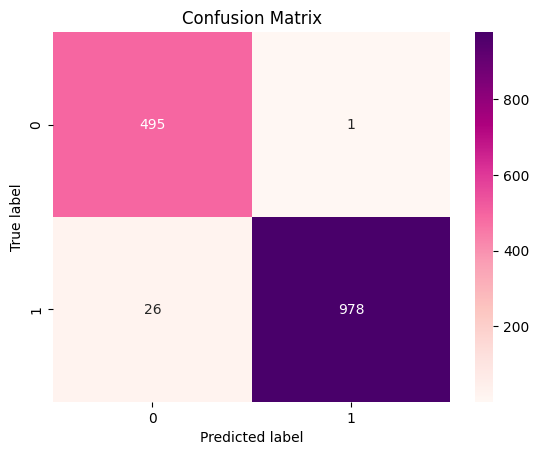

In [52]:
#Create confusion matrix
result_final = pd.DataFrame({'Actual': test_label.flatten(), 'Predicted': y_pred_int.flatten()})

#confusion matrix
cm = confusion_matrix(result_final['Actual'], result_final['Predicted'])

#heatmap for confusion matrix
sns.heatmap(cm, annot=True, cmap='RdPu', fmt='g')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [20]:
#Check outputs manually
for i in range (10):
    x = 456+i
    pred = model.predict(test_data[x:x+1])
    print('Prediction:',np.round(pred).astype(int))
    print('Real:',test_label[x:x+1])
    print('*******')

1/1 [==============================] - 0s 23ms/step
Prediction: [[1]]
Real: [1]
*******
1/1 [==============================] - 0s 24ms/step
Prediction: [[0]]
Real: [0]
*******
1/1 [==============================] - 0s 23ms/step
Prediction: [[0]]
Real: [0]
*******
1/1 [==============================] - 0s 25ms/step
Prediction: [[0]]
Real: [0]
*******
1/1 [==============================] - 0s 22ms/step
Prediction: [[1]]
Real: [1]
*******
1/1 [==============================] - 0s 23ms/step
Prediction: [[1]]
Real: [1]
*******
1/1 [==============================] - 0s 23ms/step
Prediction: [[1]]
Real: [1]
*******
1/1 [==============================] - 0s 22ms/step
Prediction: [[1]]
Real: [1]
*******
1/1 [==============================] - 0s 24ms/step
Prediction: [[1]]
Real: [1]
*******
1/1 [==============================] - 0s 24ms/step
Prediction: [[1]]
Real: [1]
*******
